3. Compare o desempenho obtido considerando diferentes linguages. Por exemplo, indicando qual das linguagens tiram melhor partido do PowerCap.

Analizar a relação Package(PowerConsumption+Memory) e Time (Execution Time) em cada PowerLimit. As que tem melhor relação (Power Consumption Baixo e Execution Time Baixo) são melhores.

In [52]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as py
from sklearn.neighbors import KernelDensity
from scipy.stats import anderson
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

      Program  PowerLimit    Package       Core  Time  Temperature  Memory
0   real/grep          -1  72.903320  65.487793  2967         45.1    5920
1   real/grep          -1  72.392822  64.819519  2950         47.3    6240
2   real/grep          -1  75.767273  67.646912  3108         49.1    6080
3   real/grep          -1  73.907654  66.416260  2954         49.0    6080
4   real/grep          -1  74.116394  66.502380  2968         50.8    6080


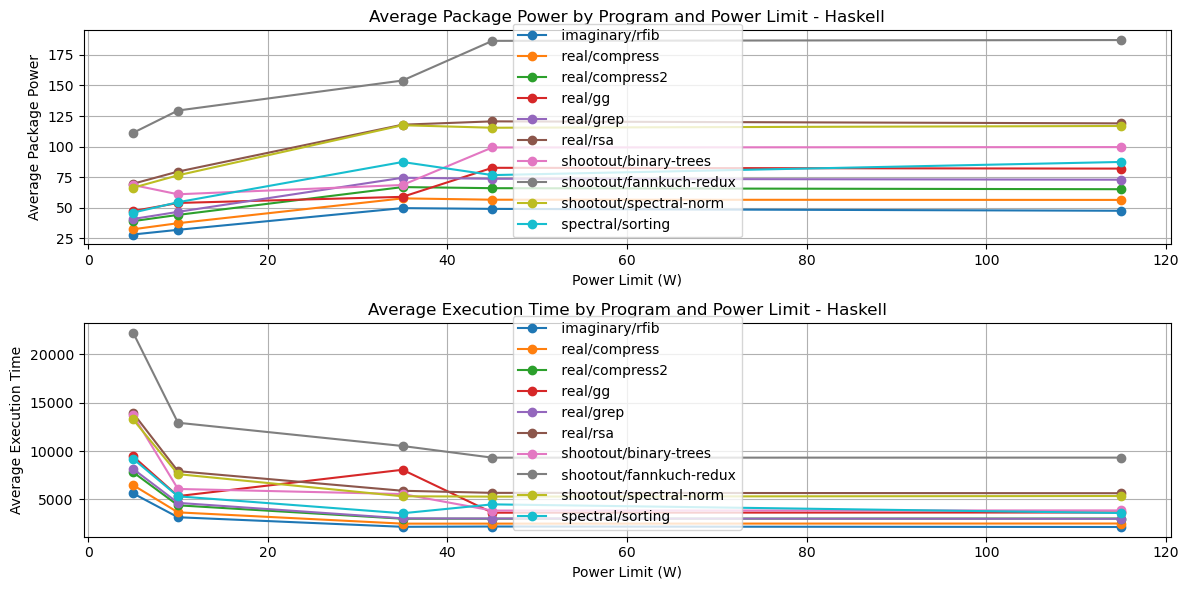

In [53]:
# Load the data from the CSV file
data_Haskell = pd.read_csv('measurements_haskell.csv')

# Display the first few rows of the Data_HaskellFrame

data_Haskell = data_Haskell.drop(['Language','DRAM', 'GPU'], axis=1)
print(data_Haskell.head())
# Ensure the 'Package' and 'Time' columns are numeric, converting any non-numeric values to NaN
#data_Haskell['Package'] = pd.to_numeric(data_Haskell['Package'], errors='coerce')
data_Haskell['PowerLimit'] = pd.to_numeric(data_Haskell['PowerLimit'], errors='coerce')
data_Haskell['Time'] = pd.to_numeric(data_Haskell['Time'], errors='coerce')

# Drop rows with NaN values in 'Package', 'Program', 'PowerLimit', or 'Time' columns
data_Haskell = data_Haskell.dropna(subset=[ 'Program', 'PowerLimit', 'Time'])

# Remove potential duplicates
data_Haskell = data_Haskell.drop_duplicates()

data_Haskell = data_Haskell[data_Haskell['PowerLimit'] != -1]
data_Haskell = data_Haskell[data_Haskell['Core'] > 0]
data_Haskell = data_Haskell[data_Haskell['Package'] > 0]

# Ensure that 'Program' is treated as a categorical variable
data_Haskell['Program'] = data_Haskell['Program'].astype('category')

# Group by 'Program' and 'PowerLimit' and calculate the mean package power and mean execution time
grouped_data_Haskell = data_Haskell.groupby(['Program', 'PowerLimit']).agg({
    'Package': 'mean',
    'Time': 'mean'
}).reset_index()

# Plotting the data_Haskell
plt.figure(figsize=(12, 6))

# Plot average package power by program and power limit
plt.subplot(2, 1, 1)
for program in grouped_data_Haskell['Program'].unique():
    subset = grouped_data_Haskell[grouped_data_Haskell['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Package'], label=program, marker='o')

plt.title('Average Package Power by Program and Power Limit - Haskell')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Package Power')
plt.legend()
plt.grid(True)

# Plot average execution time by program and power limit
plt.subplot(2, 1, 2)
for program in grouped_data_Haskell['Program'].unique():
    subset = grouped_data_Haskell[grouped_data_Haskell['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Time'], label=program, marker='o')

plt.title('Average Execution Time by Program and Power Limit - Haskell')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Execution Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
data_Haskell.head()

,Program,PowerLimit,Package,Core,Time,Temperature,Memory
100,real/grep,5,41.184509,21.308289,8239,38.5,5760
101,real/grep,5,40.809937,21.335938,8153,38.6,5760
102,real/grep,5,40.823059,21.350037,8151,38.6,5760
103,real/grep,5,40.877319,21.446289,8185,38.4,5920
104,real/grep,5,40.550293,21.287170,8127,38.9,6080


In [55]:
# REMOVE OUTLIERS IN EACH POWERLIMIT GROUP FOR EACH PROGRAM

grouped_df = data_Haskell.groupby(['Program', 'PowerLimit'])
def remove_outliers(group):
    # Remove outliers from 'Time' column
    Q1_time = group['Time'].quantile(0.25)
    Q3_time = group['Time'].quantile(0.75)
    IQR_time = Q3_time - Q1_time
    mask_time = (group['Time'] >= (Q1_time - 1.5 * IQR_time)) & (group['Time'] <= (Q3_time + 1.5 * IQR_time))

    # Remove outliers from 'Package' column
    Q1_package = group['Package'].quantile(0.25)
    Q3_package = group['Package'].quantile(0.75)
    IQR_package = Q3_package - Q1_package
    mask_package = (group['Package'] >= (Q1_package - 1.5 * IQR_package)) & (group['Package'] <= (Q3_package + 1.5 * IQR_package))

    # Combine the masks for both columns
    mask = mask_time & mask_package

    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
print(cleaned_df.groupby(['Program','PowerLimit']).count())


                                     Package  Core  Time  Temperature  Memory
Program                  PowerLimit                                          
 imaginary/rfib          5                10    10    10           10      10
                         10                8     8     8            8       8
                         35                8     8     8            8       8
                         45               10    10    10           10      10
                         115               9     9     9            9       9
 real/compress           5                10    10    10           10      10
                         10               10    10    10           10      10
                         35               10    10    10           10      10
                         45                8     8     8            8       8
                         115              10    10    10           10      10
 real/compress2          5                 8     8     8        

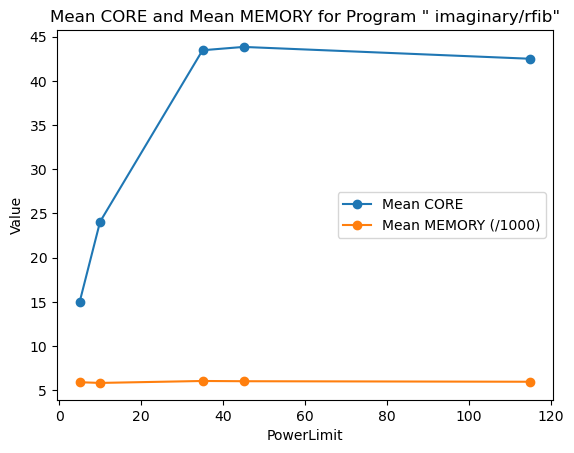

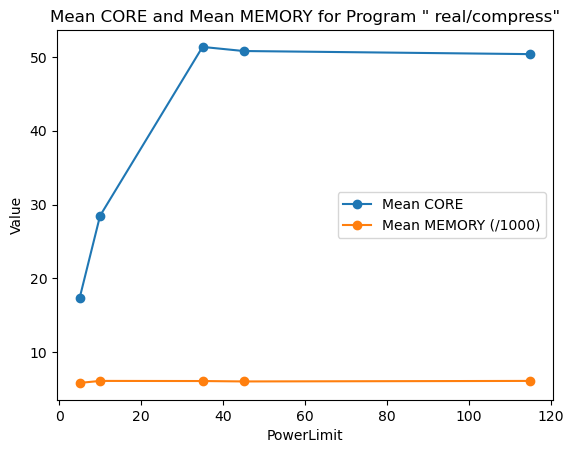

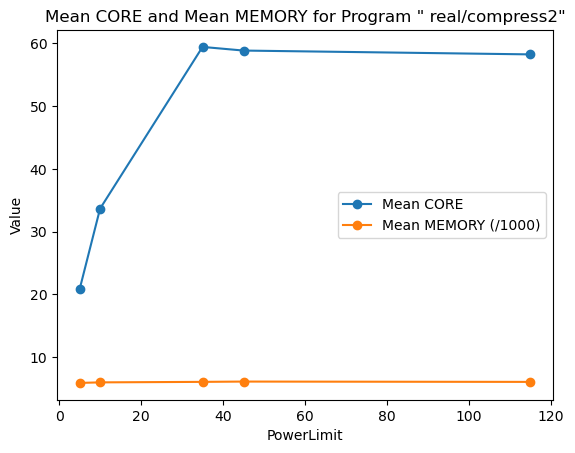

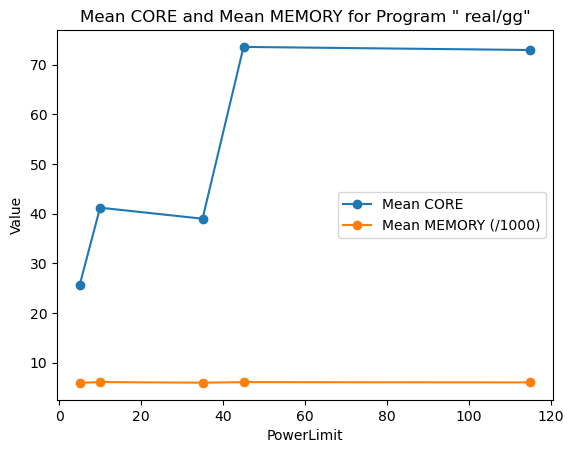

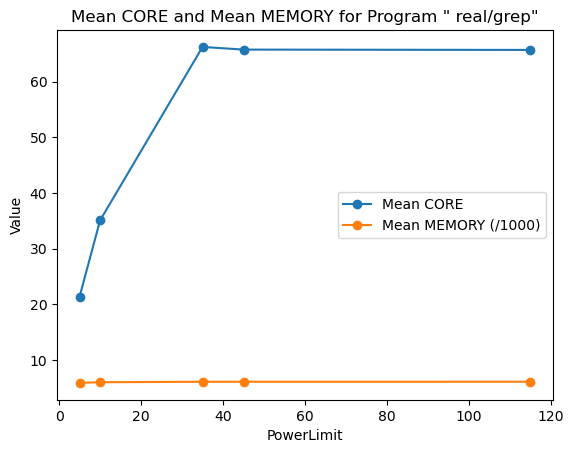

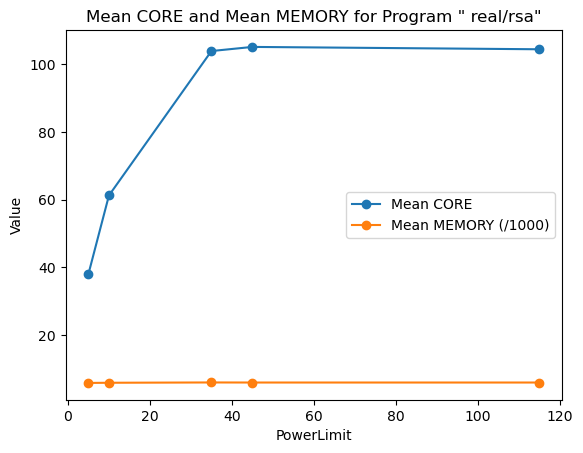

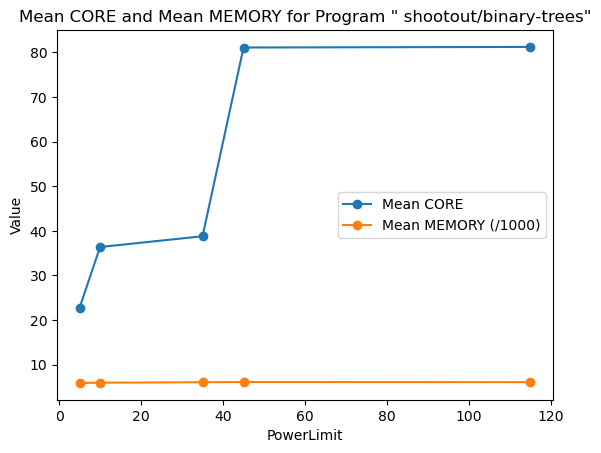

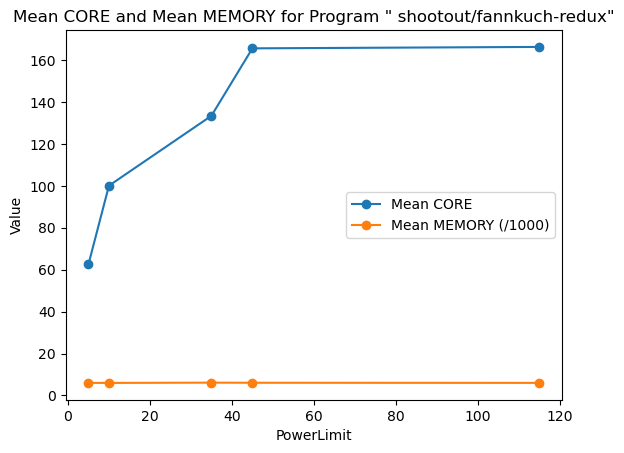

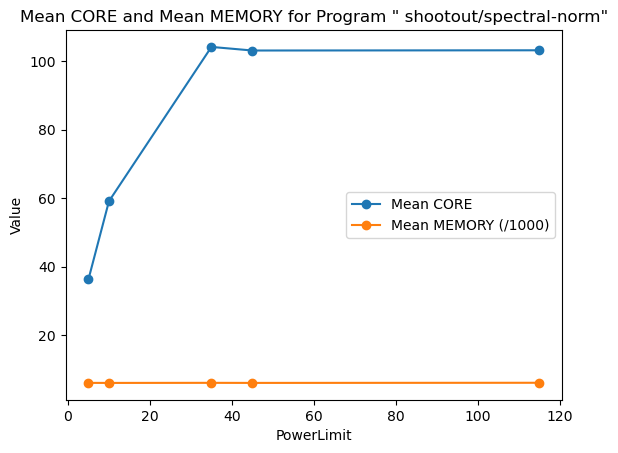

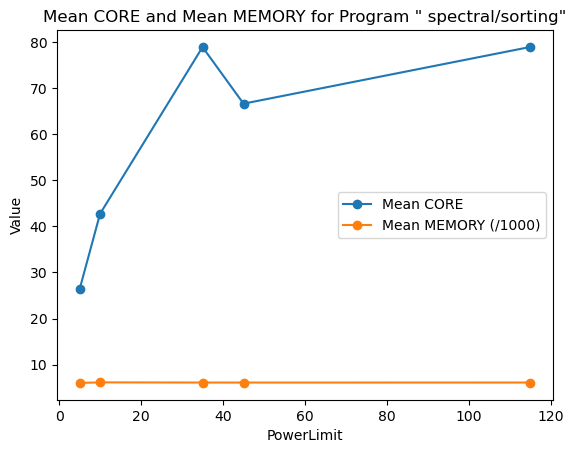

In [56]:
grouped = cleaned_df.groupby('Program')

def show_plot_Core_Memory(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_core = []
    mean_memory = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_core.append(power_group['Core'].mean())
        mean_memory.append(power_group['Memory'].mean()/1000)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_core, 'o-', label='Mean CORE')
    plt.plot(power_groups.groups.keys(), mean_memory, 'o-', label='Mean MEMORY (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean CORE and Mean MEMORY for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Core_Memory(name, program_group)

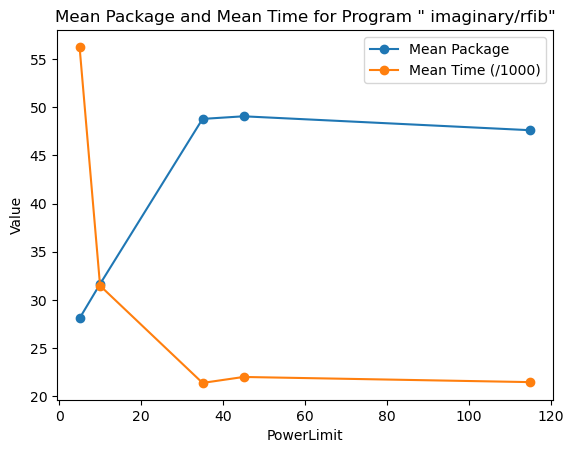

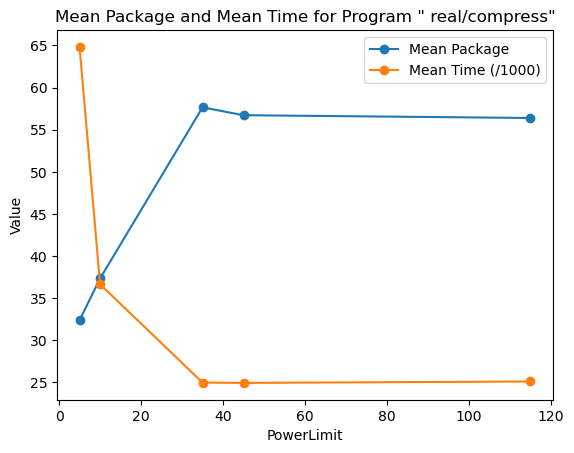

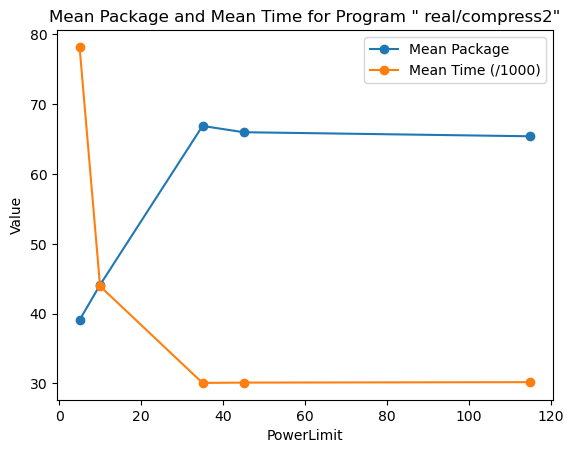

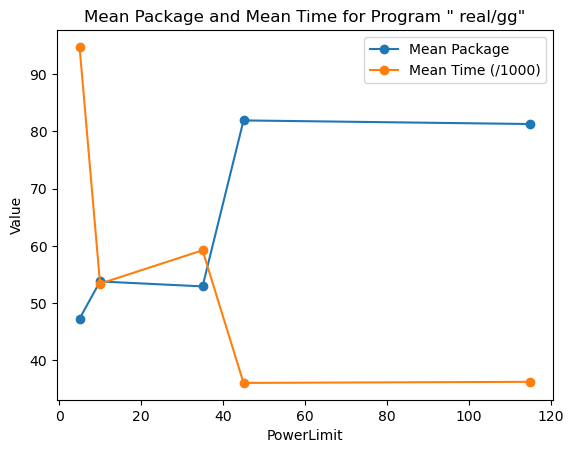

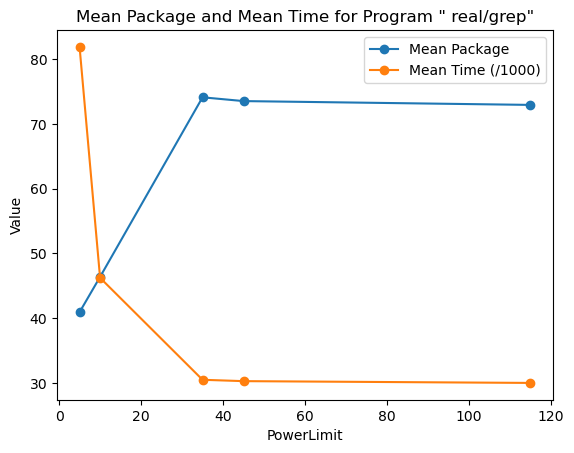

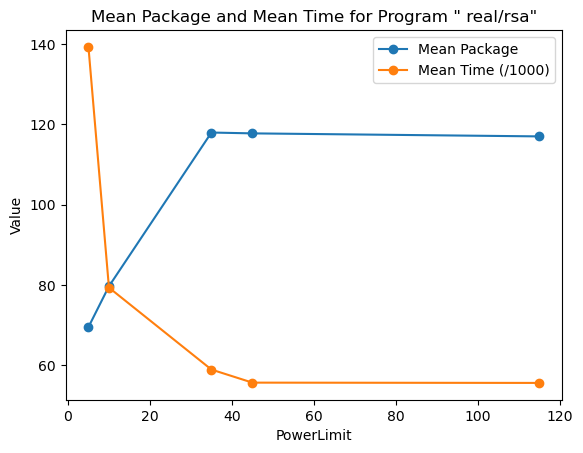

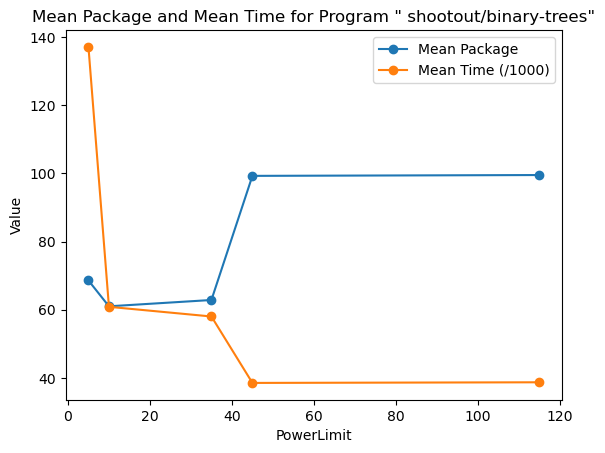

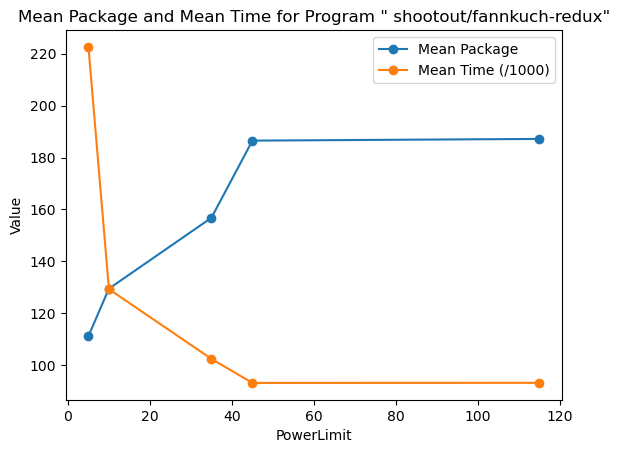

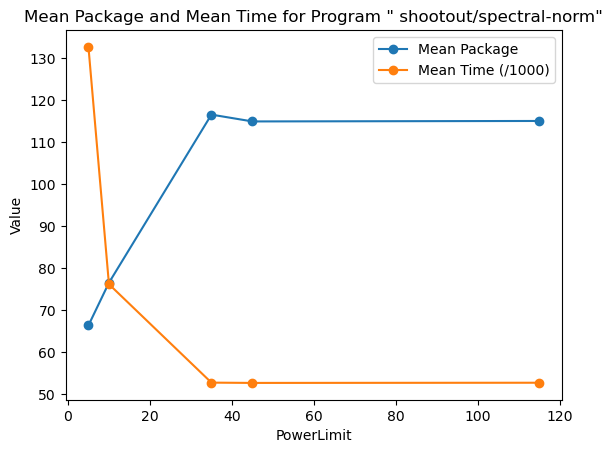

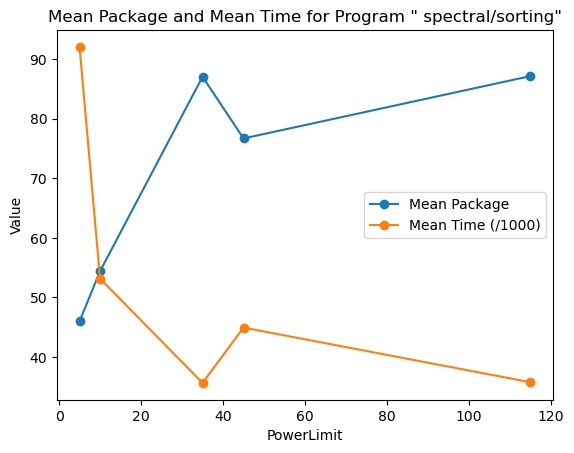

In [57]:
def show_plot_Package_Time(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_package = []
    mean_time = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_package.append(power_group['Package'].mean())
        mean_time.append(power_group['Time'].mean()/100)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_package, 'o-', label='Mean Package')
    plt.plot(power_groups.groups.keys(), mean_time, 'o-', label='Mean Time (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean Package and Mean Time for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Package_Time(name, program_group)

In [58]:
def show_stats(name, program_group):
    # Calculate the correlation coefficient between Time and Package
    corr_coef, p_value = stats.pearsonr(program_group['Time'], program_group['Package'])
    print(f"Program: {name}")
    print(f"Correlation coefficient between Time and Package: {corr_coef:.3f}")
    print(f"P-value: {p_value:.5f}")

    # Perform linear regression between Time and Package
    slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['Package'], program_group['Time'])
    print(f"Linear regression results:")
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.5f}")
    print(f"Standard error: {std_err:.3f}")
    print("-" * 30)

# Apply the show_stats function to each group
for name, program_group in grouped:
    show_stats(name, program_group)

Program:  imaginary/rfib
Correlation coefficient between Time and Package: -0.883
P-value: 0.00000
Linear regression results:
Slope: -132.079
Intercept: 8518.940
R-squared: 0.780
P-value: 0.00000
Standard error: 10.684
------------------------------
Program:  real/compress
Correlation coefficient between Time and Package: -0.886
P-value: 0.00000
Linear regression results:
Slope: -125.314
Intercept: 9554.636
R-squared: 0.786
P-value: 0.00000
Standard error: 9.648
------------------------------
Program:  real/compress2
Correlation coefficient between Time and Package: -0.870
P-value: 0.00000
Linear regression results:
Slope: -128.482
Intercept: 11426.133
R-squared: 0.756
P-value: 0.00000
Standard error: 10.868
------------------------------
Program:  real/gg
Correlation coefficient between Time and Package: -0.840
P-value: 0.00000
Linear regression results:
Slope: -121.731
Intercept: 13339.912
R-squared: 0.705
P-value: 0.00000
Standard error: 12.149
------------------------------
Program

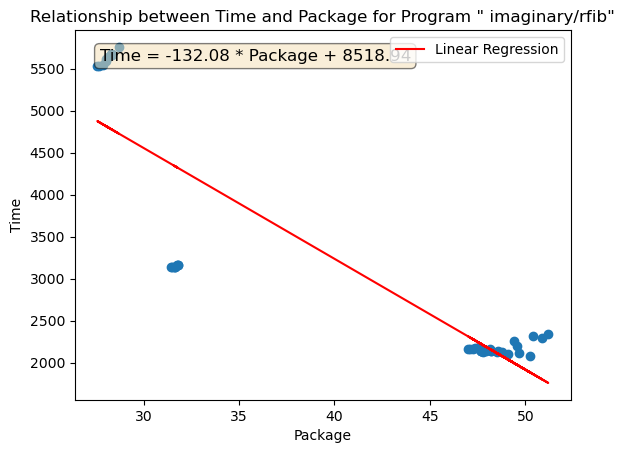

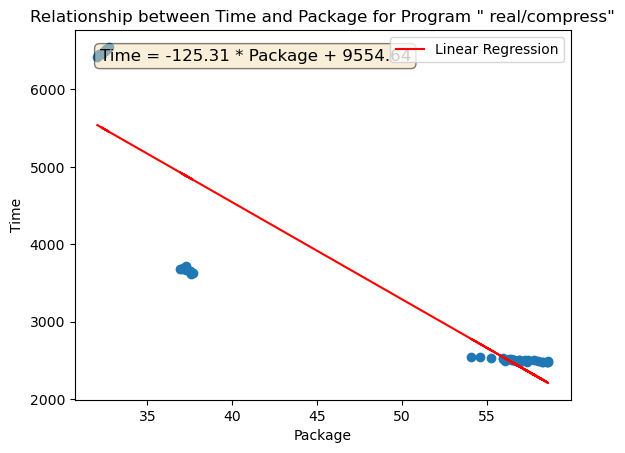

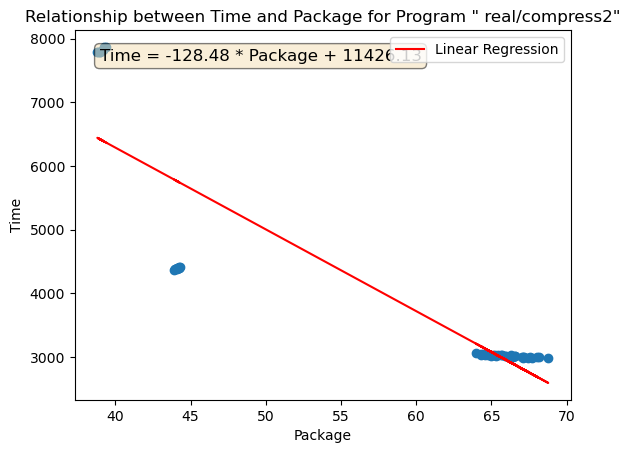

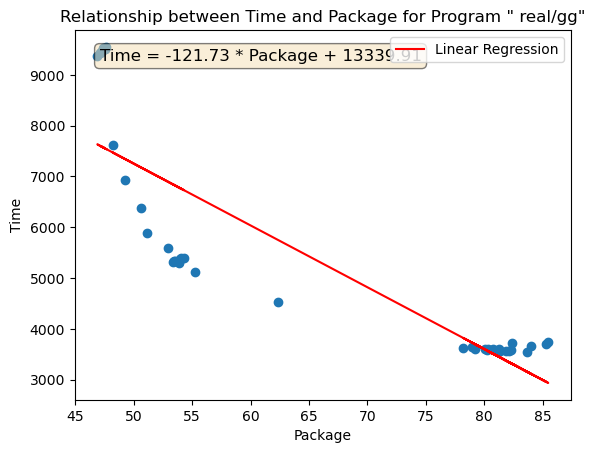

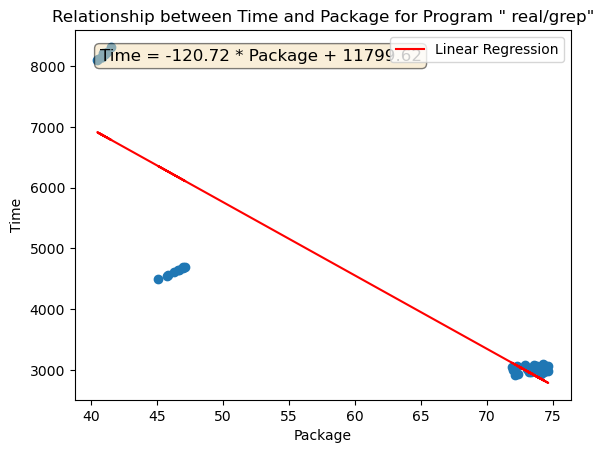

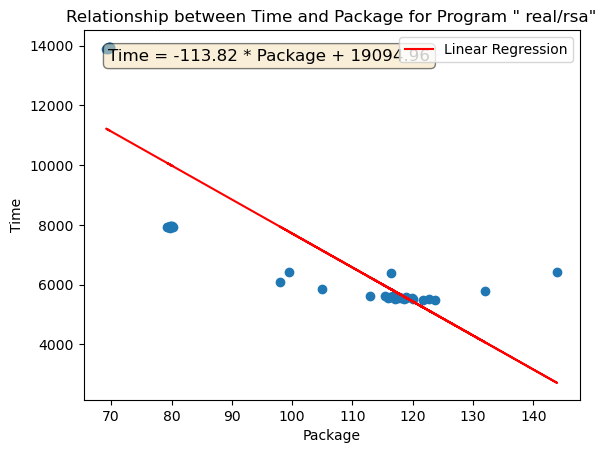

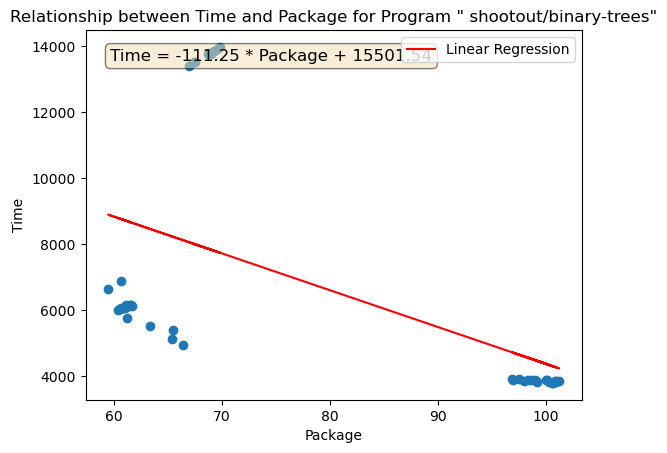

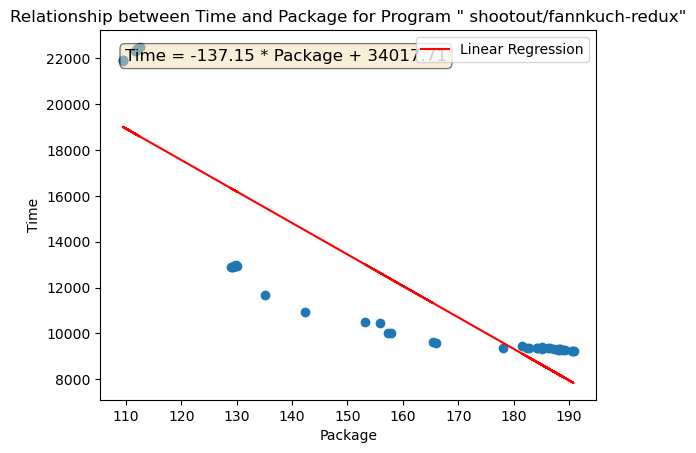

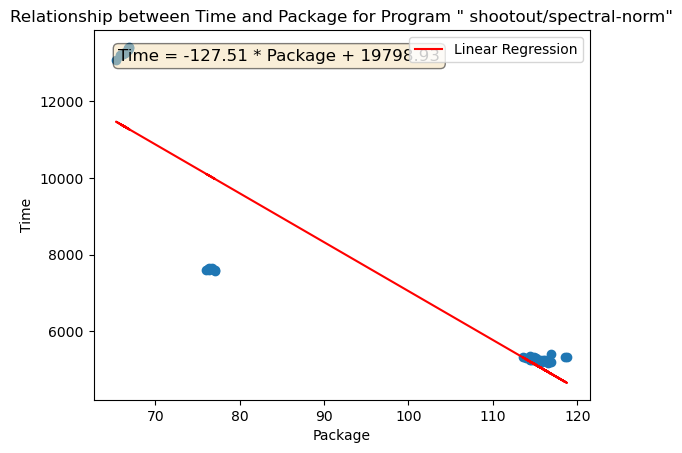

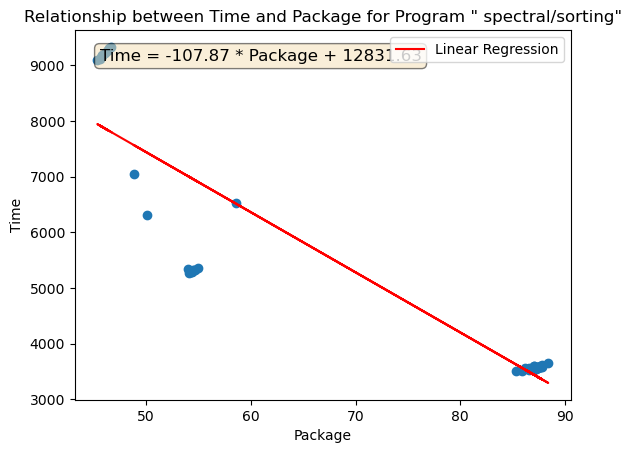

In [59]:
def show_scatter_plot(name, program_group):
    # Create a new figure for each program
    plt.figure()

    # Create a scatter plot of Time vs Package
    plt.scatter(program_group['Package'], program_group['Time'])

    # Perform linear regression between Time and Package
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])

    # Calculate the regression line
    x_values = program_group['Package']
    y_values = slope * x_values + intercept

    # Plot the regression line
    plt.plot(x_values, y_values, 'r', label='Linear Regression')

    # Display the regression equation
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Set labels and title
    plt.xlabel('Package')
    plt.ylabel('Time')
    plt.title(f'Relationship between Time and Package for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_scatter_plot function to each group
for name, program_group in grouped:
    show_scatter_plot(name, program_group)


In [60]:
regression_equations = {}
slope_vals = []
intercept_vals = []

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    slope_vals.append(slope)
    intercept_vals.append(intercept)
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

# Print the regression equations
for program, equation in regression_equations.items():
    print(f"Program: {program}")
    print(f"Regression equation: {equation}")
    print("-" * 30)

print("Average slope:", py.mean(slope_vals))
print("Average intercept:", py.mean(intercept_vals))

Program:  imaginary/rfib
Regression equation: Time = -132.08 * Package + 8518.94
------------------------------
Program:  real/compress
Regression equation: Time = -125.31 * Package + 9554.64
------------------------------
Program:  real/compress2
Regression equation: Time = -128.48 * Package + 11426.13
------------------------------
Program:  real/gg
Regression equation: Time = -121.73 * Package + 13339.91
------------------------------
Program:  real/grep
Regression equation: Time = -120.72 * Package + 11799.62
------------------------------
Program:  real/rsa
Regression equation: Time = -113.82 * Package + 19094.96
------------------------------
Program:  shootout/binary-trees
Regression equation: Time = -111.25 * Package + 15501.54
------------------------------
Program:  shootout/fannkuch-redux
Regression equation: Time = -137.15 * Package + 34017.71
------------------------------
Program:  shootout/spectral-norm
Regression equation: Time = -127.51 * Package + 19798.93
-----------

In [61]:
package_range = range(4, 7)

for program, equation in regression_equations.items():
    print(f"Program: {program}")
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = slope * package + intercept
        print(f"Package: {package}, Time: {time:.2f}")
    print("-" * 30)

Program:  imaginary/rfib
Package: 4, Time: 7990.62
Package: 5, Time: 7858.54
Package: 6, Time: 7726.46
------------------------------
Program:  real/compress
Package: 4, Time: 9053.40
Package: 5, Time: 8928.09
Package: 6, Time: 8802.78
------------------------------
Program:  real/compress2
Package: 4, Time: 10912.21
Package: 5, Time: 10783.73
Package: 6, Time: 10655.25
------------------------------
Program:  real/gg
Package: 4, Time: 12852.99
Package: 5, Time: 12731.26
Package: 6, Time: 12609.53
------------------------------
Program:  real/grep
Package: 4, Time: 11316.74
Package: 5, Time: 11196.02
Package: 6, Time: 11075.30
------------------------------
Program:  real/rsa
Package: 4, Time: 18639.68
Package: 5, Time: 18525.86
Package: 6, Time: 18412.04
------------------------------
Program:  shootout/binary-trees
Package: 4, Time: 15056.54
Package: 5, Time: 14945.29
Package: 6, Time: 14834.04
------------------------------
Program:  shootout/fannkuch-redux
Package: 4, Time: 33469.1

In [62]:
# Define a range of Package values to evaluate
package_range = range(4, 250)

# Define weights for Time and Package
time_weight = 0.5
package_weight = 0.5

best_score = float('inf')
best_program = None
overall_scores = []

for program, equation in regression_equations.items():
    total_score = 0
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = max(slope * package + intercept, 0)
        score = time_weight * time + package_weight * package
        total_score += score
    
    average_score = total_score / len(package_range)
    overall_scores.append(average_score)
    
    if average_score < best_score:
        best_score = average_score
        best_program = program

    
    
    print(f"Program: {program}")
    print(f"Equation: {equation}")
    print(f"Average score: {average_score:.2f}")
    print("-" * 30)

print(f"The best program is: {best_program}")

overall_average_score = sum(overall_scores) / len(overall_scores)
print(f"\nOverall average score of Haskell Language: {overall_average_score:.2f}")

Program:  imaginary/rfib
Equation: Time = -132.08 * Package + 8518.94
Average score: 562.68
------------------------------
Program:  real/compress
Equation: Time = -125.31 * Package + 9554.64
Average score: 737.20
------------------------------
Program:  real/compress2
Equation: Time = -128.48 * Package + 11426.13
Average score: 1016.23
------------------------------
Program:  real/gg
Equation: Time = -121.73 * Package + 13339.91
Average score: 1455.51
------------------------------
Program:  real/grep
Equation: Time = -120.72 * Package + 11799.62
Average score: 1152.90
------------------------------
Program:  real/rsa
Equation: Time = -113.82 * Package + 19094.96
Average score: 3184.37
------------------------------
Program:  shootout/binary-trees
Equation: Time = -111.25 * Package + 15501.54
Average score: 2149.46
------------------------------
Program:  shootout/fannkuch-redux
Equation: Time = -137.15 * Package + 34017.71
Average score: 8397.64
------------------------------
Program

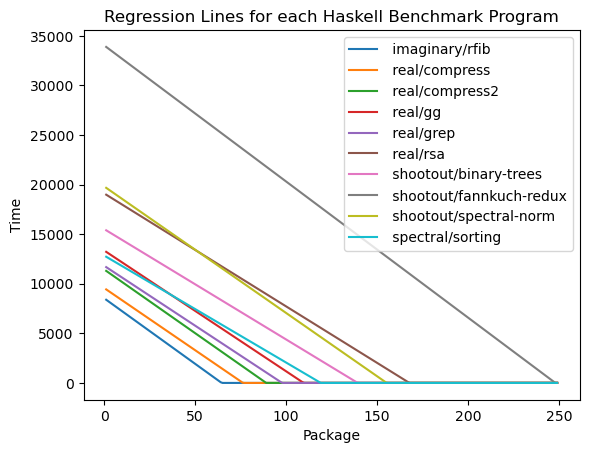

In [63]:
regression_equations = {}

# Create a figure and axis objects
fig, ax = plt.subplots()

# Define a range of Package values to evaluate
package_range = range(1, 250)

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

    # Calculate the regression line
    x_values = package_range
    y_values = [max(slope * x + intercept, 0) for x in x_values]

    # Plot the regression line
    ax.plot(x_values, y_values, label=name)

# Set labels, title, and legend
ax.set_xlabel('Package')
ax.set_ylabel('Time')
ax.set_title('Regression Lines for each Haskell Benchmark Program')
ax.legend()

# Show the plot
plt.show()

## Conclusion


Haskell shows a great improvement in Execution Time when Powercap is increased. This means that per unit of powercap changed, there's a big diference in time. Statistically we can predict time with a linear regression equation , Time = slope * Package + interecept. 

The average slope and intercept across benchmarks is :

    - Average slope: -122.59285485123603 
    - Average intercept: 15588.401082407878
  
The team created a custom score which takes into acount Time values and Package values, meaning a higher score the worst it is. 

The average score for haskell between 1-250 in package values is 2322.87. 

Haskell, compared to Python and Java, also benefits from lighterheight benchmarks. 

